In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import pairwise_distances_argmin

%matplotlib inline

# K-Means Clustering & Principal Component Analysis

## K-means Clustering
In this this exercise, you will implement the K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After that, you wil use the K-means algorithm for image compression by reducing
the number of colors that occur in an image to only those that are most common in that image.

### Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

In [12]:
data  = loadmat('data/ex7data2.mat')
X = data['X']

### Random initialization

The initial assignments of centroids for the example dataset in ex7.m were designed so that you will see the same figure as in Figure 1. In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In [13]:
def find_clusters(X, n_clusters, rseed=2):
    
    #Randomly choose clusters
    rand_clust = np.random.RandomState(rseed)
    i = rand_clust.permutation(X.shape[0])[:n_clusters]
    
    centers = X[i]
    
    while True:
        #Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        #Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        #Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

In [14]:
centers, labels  = find_clusters(X, 3)

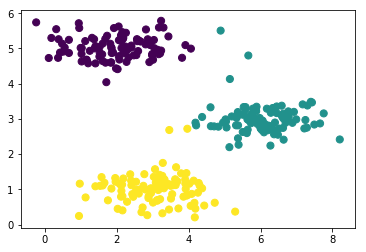

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50,);

## Image compression with K-means

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image,1 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as
the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

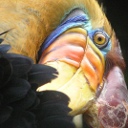

In [16]:
from  IPython.display import Image
Image(filename='data/bird_small.png')

In [17]:
image_data = loadmat('data/bird_small.mat')

### K-means on pixels

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the findClosestCentroids function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 X 128 pixel locations, resulting in total size of 128 X 128 X 24 = 393; 216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location.

In [18]:
bird = image_data['A']

In [19]:
bird = bird / 255.0
data = bird.reshape((bird.shape[0] * bird.shape[1], bird.shape[2]))
data.shape

(16384, 3)

In [20]:
centers, labels = find_clusters(data, 16)

In [21]:
labels = pairwise_distances_argmin(data, centers)

Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. The recovered values will also need to be reshaped back into the shape of the bird image.

In [22]:
X_recovered = centers[labels.astype(int),:]
X_recovered = X_recovered.reshape((bird.shape[0], bird.shape[1], bird.shape[2]))

X_recovered.shape

(128, 128, 3)

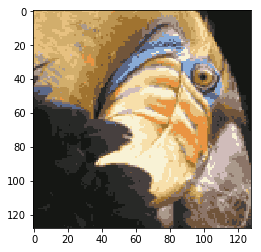

In [23]:
plt.imshow(X_recovered);

## Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

In [24]:
data = loadmat('data/ex7data1.mat')

In [25]:
X  =  data['X']

To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation.

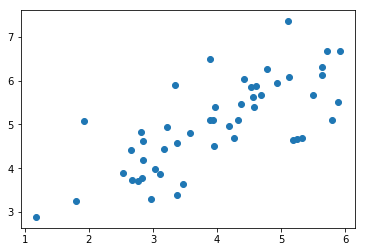

In [26]:
plt.scatter(X[:, 0], X[:, 1]);

### Implementing PCA

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: First, you compute the covariance matrix of the data.

Then, you use Octave's SVD function to compute the eigenvectors. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [27]:
def pca(X):
    # normalize
    X = (X - X.mean()) / X.std()
    
    #compute covariance matrix
    X =np.array(X)
    cov = (X.T.dot(X)) / X.shape[0]
    
    #SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

In [28]:
U, S, V = pca(X)

In [29]:
U, S, V

(array([[-0.79241747, -0.60997914],
        [-0.60997914,  0.79241747]]),
 array([1.43584536, 0.56415464]),
 array([[-0.79241747, -0.60997914],
        [-0.60997914,  0.79241747]]))

### Dimensionality Reduction with PCA
After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space. 

In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space. In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

### Projecting the data onto the principal components

In [30]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return X.dot(U_reduced)

### Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space.

In [31]:
def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return Z.dot(U_reduced.T)

In [32]:
Z = project_data(X, U, 1)
data_recovered = recover_data(Z, U, 1)

### Visualizing the projections

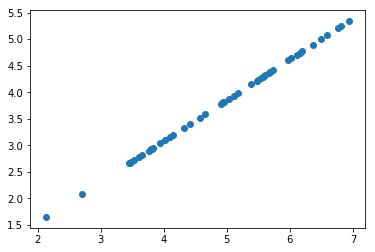

In [33]:
plt.scatter(data_recovered[:, 0], data_recovered[:, 1]);

## Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction.

Each row of X corresponds to one face image (a row vector of length 1024).

In [34]:
faces = loadmat('data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [35]:
face = np.reshape(X[3,:], (32, 32)).T

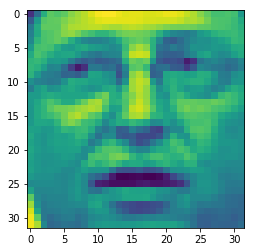

In [36]:
plt.imshow(face);

### PCA on Faces

To run PCA on the face dataset, we first normalize the dataset by subtracting
the mean of each feature from the data matrix X.

After running PCA, you will obtain the principal components of the dataset. Notice that each principal
component in U (each row) is a vector of length n (where for the face dataset, n = 1024).

In [37]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

### Dimensionality Reduction

In [38]:
face_recovered = recover_data(Z, U, 100)

In [39]:
face_rec = np.reshape(face_recovered[3,:], (32, 32)).T

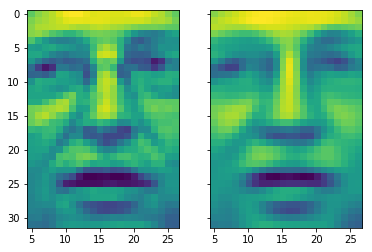

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(face)
ax2.imshow(face_rec);

Not bad, still very creepy!